<a href="https://colab.research.google.com/github/joe-jachim/cassava-leaf-classifier/blob/main/fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture

!pip install fastai --upgrade
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

In [3]:
files = get_image_files(path/"images")
len(files)

7390

In [4]:
files[0],files[6]

(Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_124.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_134.jpg'))

In [5]:
def label_func(f): return f[0].isupper()

In [6]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

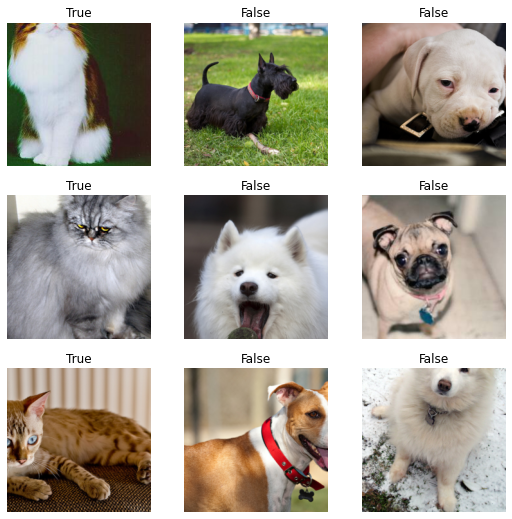

In [7]:
dls.show_batch()

In [8]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [9]:
files[0].name

'havanese_124.jpg'

In [10]:
pat = r'^(.*)_\d+.jpg'

In [11]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(224))

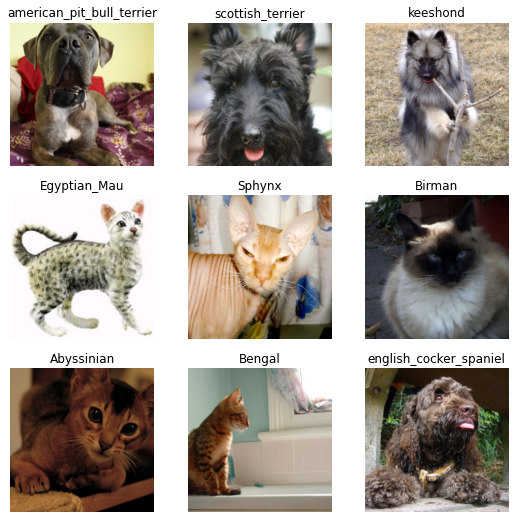

In [12]:
dls.show_batch()

In [13]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(460),
                                    batch_tfms=aug_transforms(size=224))

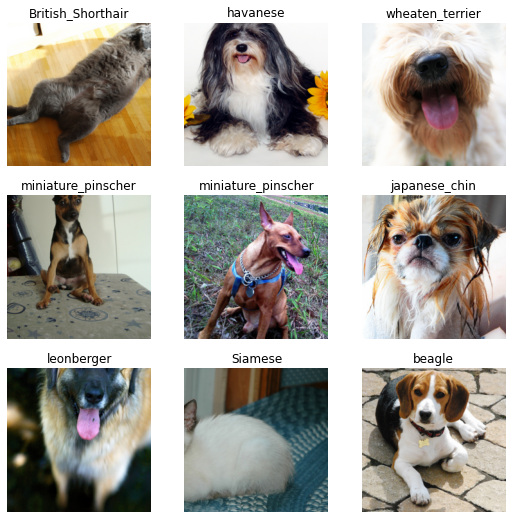

In [14]:
dls.show_batch()

In [15]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.004365158267319202)

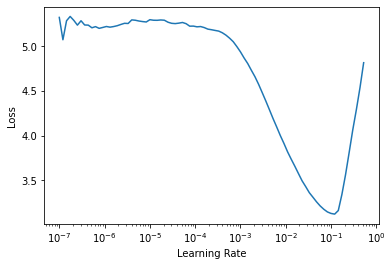

In [16]:
learn.lr_find()

In [17]:
learn.fine_tune(2, 3e-3)

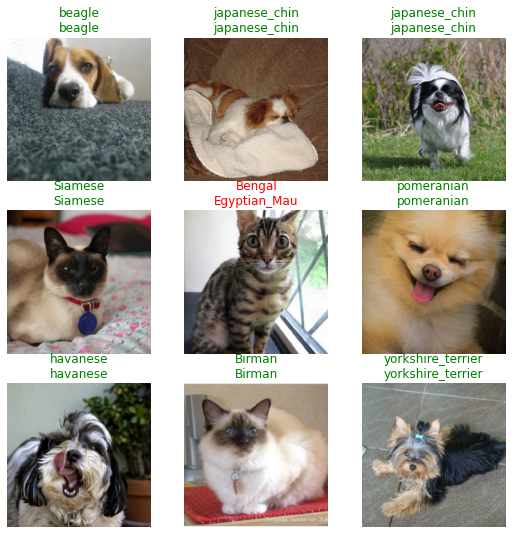

In [18]:
learn.show_results()

In [19]:
interp = Interpretation.from_learner(learn)

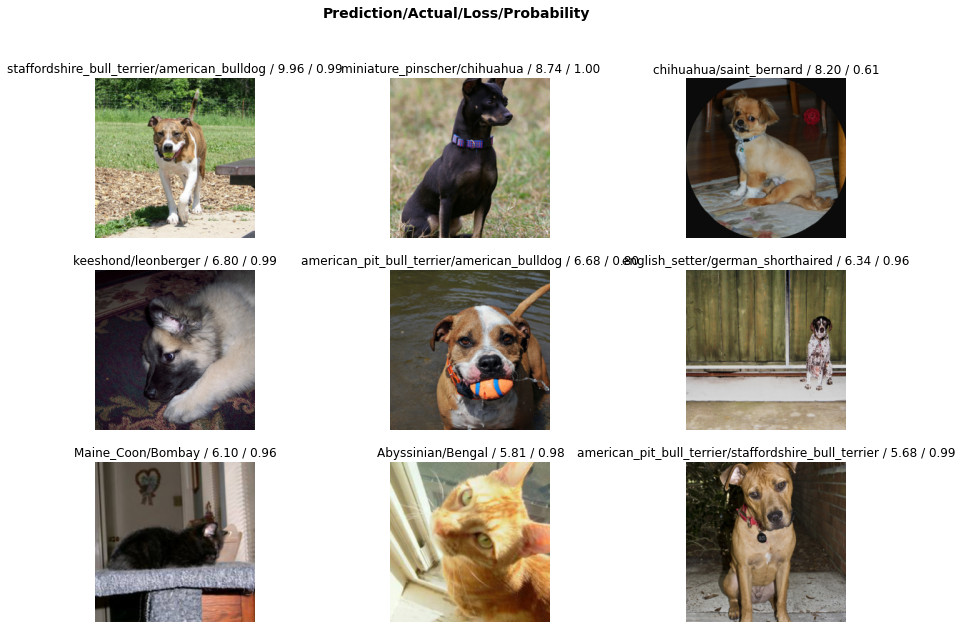

In [20]:
interp.plot_top_losses(9, figsize=(15,10))

In [21]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224))

In [22]:
dls = pets.dataloaders(untar_data(URLs.PETS)/"images")

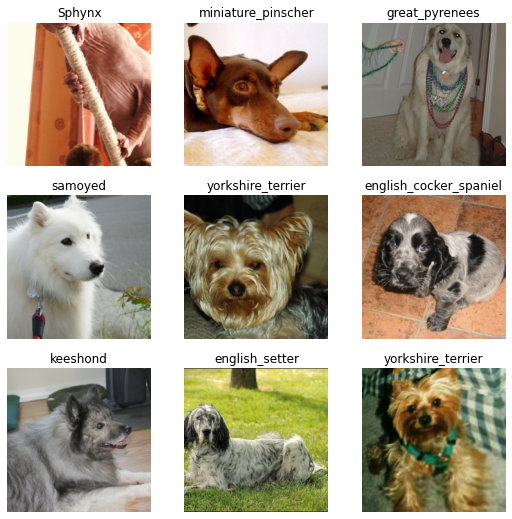

In [23]:
dls.show_batch(max_n=9)

# Multi-label


In [24]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/test')]

In [26]:
df = pd.read_csv(path/'train.csv')
df.head()

fname        labels  is_valid
0  000005.jpg         chair      True
1  000007.jpg           car      True
2  000009.jpg  horse person      True
3  000012.jpg           car     False
4  000016.jpg       bicycle      True

In [27]:
dls = ImageDataLoaders.from_df(df, path, folder='train', valid_col='is_valid', label_delim=' ',
                               item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

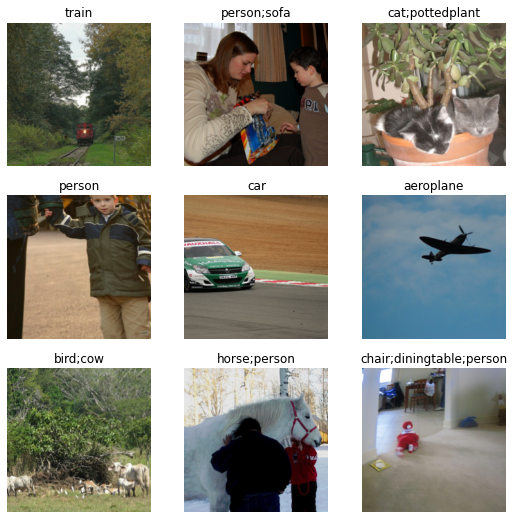

In [28]:
dls.show_batch()

In [29]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.033113110810518265)

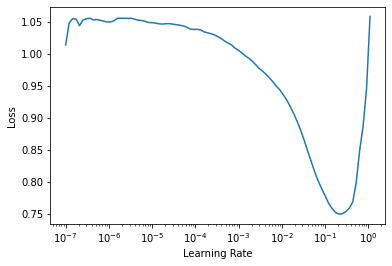

In [30]:
learn.lr_find()

In [31]:
learn.fine_tune(2, 3e-2)

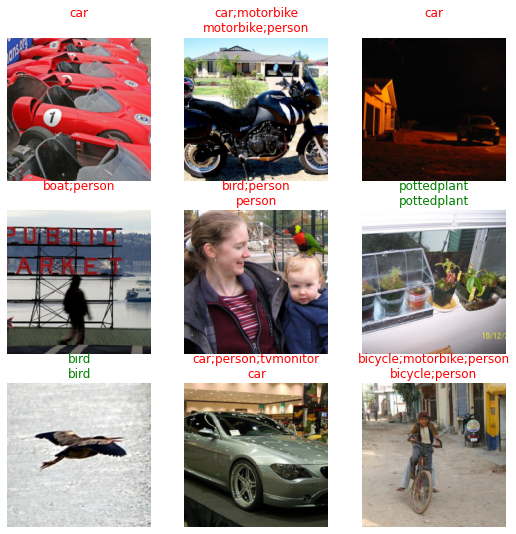

In [32]:
learn.show_results()

In [33]:
learn.predict(path/'train/000005.jpg')

((#3) ['chair','diningtable','tvmonitor'],
 tensor([False, False, False, False, False, False, False, False,  True, False,
          True, False, False, False, False, False, False, False, False,  True]),
 tensor([1.9154e-03, 1.9192e-03, 3.9618e-04, 2.5989e-04, 5.1886e-02, 5.6278e-03,
         1.2911e-02, 7.6883e-03, 9.6688e-01, 6.3730e-05, 5.3867e-01, 4.5802e-03,
         7.8882e-04, 3.6670e-04, 7.5394e-02, 1.1323e-01, 9.5358e-05, 2.4413e-01,
         4.4379e-04, 5.7512e-01]))

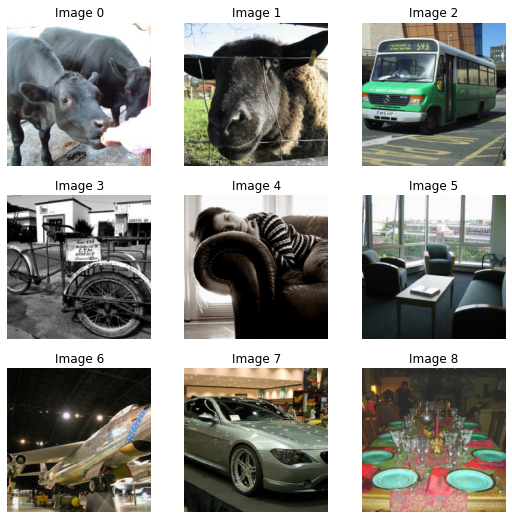

In [34]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

In [35]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter('is_valid'),
                   get_x=ColReader('fname', pref=str(path/'train') + os.path.sep),
                   get_y=ColReader('labels', label_delim=' '),
                   item_tfms = Resize(460),
                   batch_tfms=aug_transforms(size=224))

In [36]:
dls = pascal.dataloaders(df)

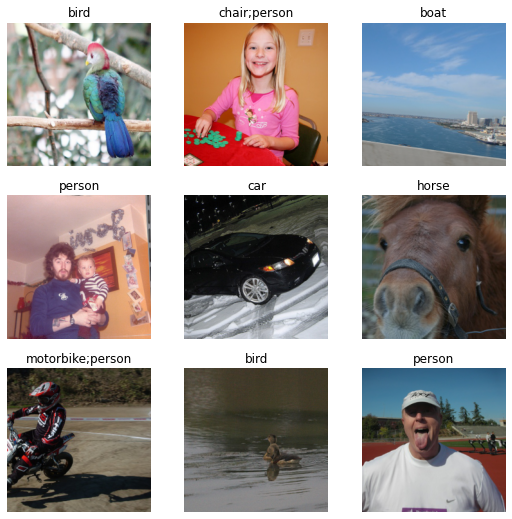

In [37]:
dls.show_batch(max_n=9)